
## Probabilistic generative models


In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpl = tfp.layers

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib import gridspec
from tensorflow.keras import models, layers, callbacks

We will create  own image dataset from contour plots of a transformed distribution using a random normalising flow network. We will then use the variational autoencoder algorithm to train generative and inference networks, and synthesise new images by interpolating in the latent space.

#### The normalising flow
* To construct the image dataset, we will build a normalising flow to transform the 2-D Gaussian random variable $z=(z_1, z_2)$, which has mean $\mathbf{0}$ and covariance matrix $\Sigma=\sigma^2\mathbf{I}_2$, with $\sigma=0.3$. 
* This normalising flow uses bijectors that are parameterised by the following random variables:
  * $\theta \sim U[0, 2\pi)$
  * $a \sim N(3, 1)$
  
The complete normalising flow is given by the following chain of transformations:
* $f_1(z) = (z_1, z_2 - 2)$,
* $f_2(z) = (z_1, \frac{z_2}{2})$,
* $f_3(z) = (z_1, z_2 + az_1^2)$,
* $f_4(z) = Rz$, where $R$ is a rotation matrix with angle $\theta$,
* $f_5(z) = \tanh(z)$, where the $\tanh$ function is applied elementwise.

The transformed random variable $x$ is given by $x = f_5(f_4(f_3(f_2(f_1(z)))))$. 
* construct bijectors for each of the transformations $f_i$, $i=1,\ldots, 5$, and use `tfb.Chain` and `tfb.TransformedDistribution` to construct the final transformed distribution. 
* Ensure to implement the `log_det_jacobian` methods for any subclassed bijectors that you write.
* Display a scatter plot of samples from the base distribution.
* Display 4 scatter plot images of the transformed distribution from your random normalising flow, using samples of $\theta$ and $a$. Fix the axes of these 4 plots to the range $[-1, 1]$.

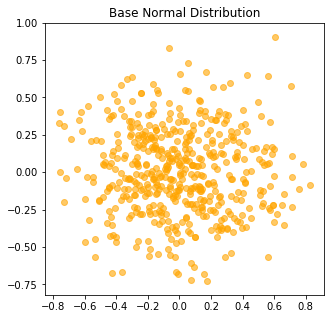

In [2]:
# Base Distribution

theta_dist = tfd.Uniform(low = 0, high = 2*np.pi)
a_dist = tfd.Normal(loc = 3, scale = 1)

mu, sigma = 0, 0.3
base_dist = tfd.MultivariateNormalDiag(loc = [mu, mu],  scale_diag = [sigma, sigma])

# Underlying Base Distribution

n = 500

z = base_dist.sample(n).numpy().squeeze()
plt.figure(figsize=(5,5))
plt.scatter(z[:, 0], z[:, 1], color="orange", alpha=0.6)
plt.title("Base Normal Distribution")
plt.show()

In [3]:
class Polynomial(tfb.Bijector):
    def __init__(self, a, name="Polynomial", **kwargs):
        super(Polynomial, self).__init__(forward_min_event_ndims=1, 
                                         name=name, 
                                         is_constant_jacobian=True, 
                                         validate_args=False, 
                                         **kwargs)
        
        self.a = tf.cast(a, dtype=tf.float32)

    def _forward(self, x):
        x = tf.cast(x, dtype=tf.float32)
        return tf.concat([x[..., 0:1], 
                          x[..., 1:] + self.a * tf.square(x[..., 0:1])], axis=-1)
    
    def _inverse(self, y):
        y = tf.cast(y, dtype=tf.float32)
        return tf.concat([y[..., 0:1], 
                          y[..., 1:] - self.a * tf.square(y[..., 0:1])], axis=-1)
        
    def _forward_log_det_jacobian(self, x):
        return tf.constant(0., dtype=x.dtype)

class Rotation(tfb.Bijector):
    def __init__(self, theta, name="Rotation", **kwargs):
        super(Rotation, self).__init__(name=name, 
                                       forward_min_event_ndims=1, 
                                       validate_args=False, 
                                       **kwargs)
        
        self.rot_matrix = tf.convert_to_tensor([[tf.cos(theta), -tf.sin(theta)], 
                                                [tf.sin(theta), tf.cos(theta)]], dtype=tf.float32)

    def _forward(self, x):
        x = tf.cast(x, dtype=tf.float32)
        return tf.linalg.matvec(self.rot_matrix, x)

    def _inverse(self, y):
        y = tf.cast(y, dtype=tf.float32)
        return tf.linalg.matvec(tf.transpose(self.rot_matrix), y)

    def _forward_log_det_jacobian(self, x):
        return tf.constant(0., dtype=x.dtype)

In [4]:
# Bijectors

def GetFlow(theta, a):
    f1 = tfb.Shift([0, -2])
    f2 = tfb.Scale([1, 0.5])
    f3 = Polynomial(a)
    f4 = Rotation(theta)
    f5 = tfb.Tanh()

    return tfb.Chain([f5, f4, f3, f2, f1])

In [5]:
# Transformed Distribution of Bijector

GetFlowDist = lambda theta, a, base_dist: tfd.TransformedDistribution(distribution=base_dist, 
                                                                      bijector=GetFlow(theta, a))

In [6]:
def PlotFlow(theta, a, flow, n_samples, color="blue"):
    samples = flow.sample(n_samples).numpy().squeeze()
    plt.scatter(samples[:,0], samples[:, 1], color=color, alpha=0.5)
    plt.title("theta = {:.2f}, a = {:.2f}".format(theta, a))
    plt.xlim([-1,1])
    plt.ylim([-1,1])

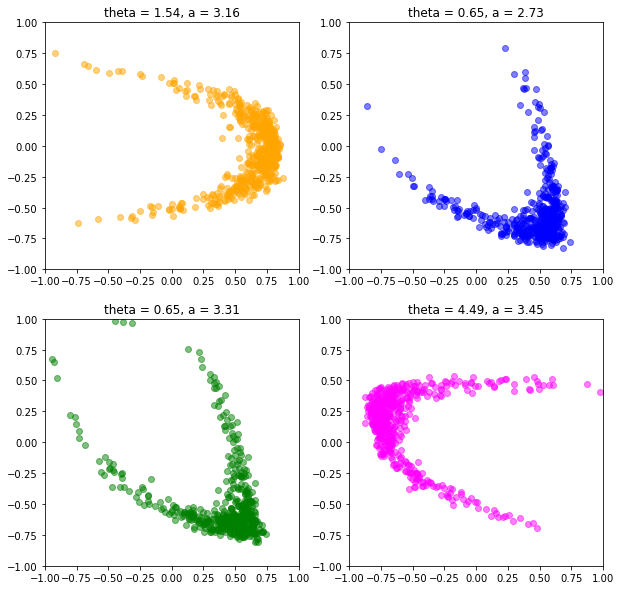

In [7]:
# Flow's Density Plots

n = 500

plt.figure(figsize = (10, 10))
for i, col in enumerate(["orange", "blue", "green", "magenta"]):
    # Parameter Sampling
    theta = theta_dist.sample(1).numpy()[0]
    a = a_dist.sample(1).numpy()[0]
    # Building a Normalizing Flow Distrubtion
    flow_dist = GetFlowDist(theta, a, base_dist)
    # Plotting the Samples.
    plt.subplot(2, 2, i+1)
    PlotFlow(theta, a, flow_dist, n, col)
plt.show()

## 2. Create the image dataset
* use our random normalising flow to generate an image dataset of contour plots from our random normalising flow network. 
  * Feel free to get creative and experiment with different architectures to produce different sets of images!
* First, display a sample of 4 contour plot images from our normalising flow network using 4 independently sampled sets of parameters. 
  * find the following `get_densities` function useful: this calculates density values for a (batched) Distribution for use in a contour plot. 
* dataset should consist of at least 1000 images, stored in a numpy array of shape `(N, 36, 36, 3)`.  Each image in the dataset should correspond to a contour plot of a transformed distribution from a normalising flow with an independently sampled set of parameters $s, T, S, b$. It will take a few minutes to create the dataset.
* As well as the `get_densities` function, the `get_image_array_from_density_values` function will help  to generate the dataset. 
* Display a sample of 20 images  generated dataset in a figure.

In [8]:
# Helper function to compute transformed distribution densities

X, Y = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
inputs = np.transpose(np.stack((X, Y)), [1, 2, 0])

def get_densities(transformed_distribution):
 
    batch_shape = transformed_distribution.batch_shape
    Z = transformed_distribution.prob(np.expand_dims(inputs, 2))
    Z = np.transpose(Z, list(range(2, 2+len(batch_shape))) + [0, 1])
    return Z

In [9]:
# Helper function to convert contour plots to numpy arrays

import numpy as np
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure

def get_image_array_from_density_values(Z):

    assert Z.shape == (100, 100)
    fig = Figure(figsize=(0.5, 0.5))
    canvas = FigureCanvas(fig)
    ax = fig.gca()
    ax.contourf(X, Y, Z, cmap='hot', levels=100)
    ax.axis('off')
    fig.tight_layout(pad=0)

    ax.margins(0)
    fig.canvas.draw()
    image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    image_from_plot = image_from_plot.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    return image_from_plot

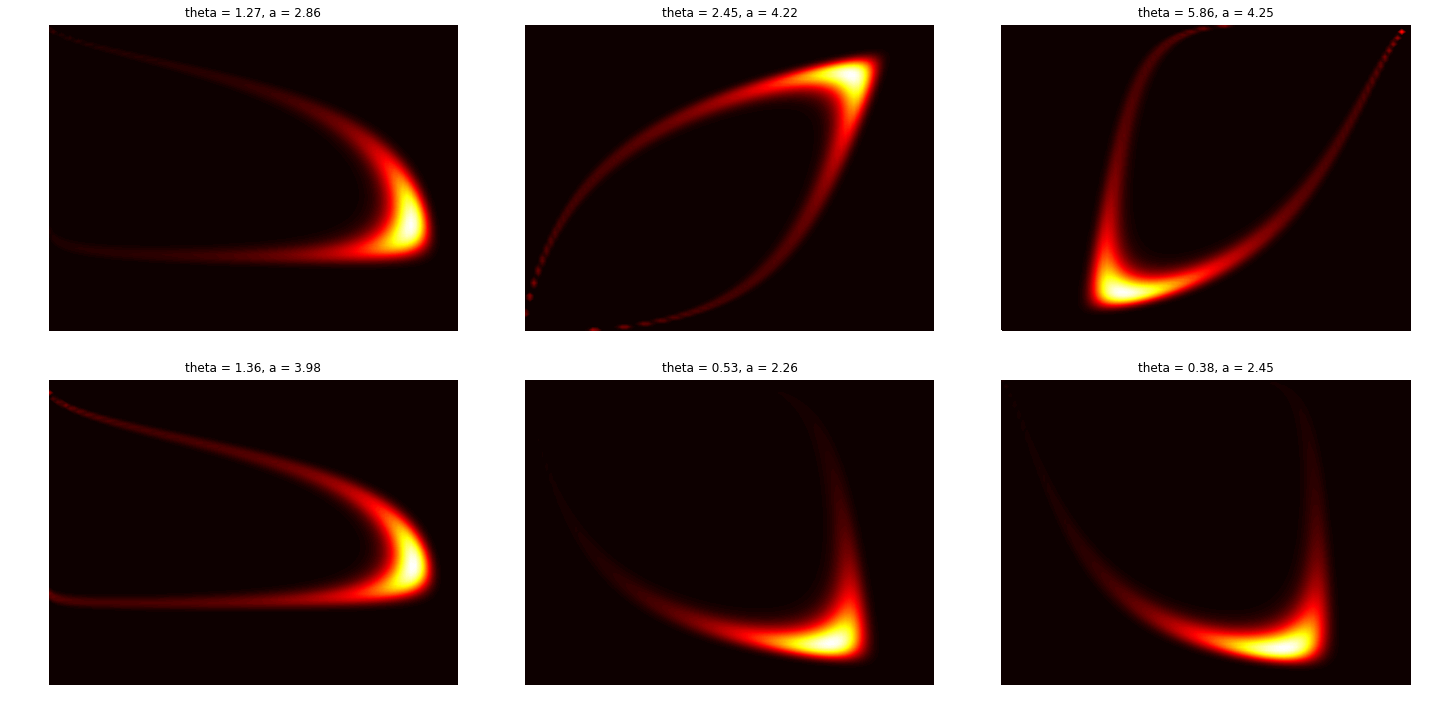

In [10]:
# Flow's Images Plots

plt.figure(figsize = (20, 10))
for i in range(6):
    # Parameter Sampling
    theta = theta_dist.sample(1).numpy()[0]
    a = a_dist.sample(1).numpy()[0]
    # Building a Normalizing Flow Distrubtion
    flow_dist = GetFlowDist(theta, a, base_dist)
    flow_dist = tfd.BatchReshape(flow_dist, [1])
    # Contour Plot
    plt.subplot(2, 3, i+1)
    plt.contourf(X, Y, get_densities(flow_dist).squeeze(), cmap='hot', levels=100)
    plt.title("theta = {:.2f}, a = {:.2f}".format(theta, a))
    plt.axis('off')
plt.tight_layout()
plt.show()

In [15]:
# Generating Images

images = []
img_params = []
N = 2500

for _ in range(N):
    # Parameter Sampling
    theta = theta_dist.sample(1).numpy()[0]
    a = a_dist.sample(1).numpy()[0]
    # Building a Normalizing Flow Distrubtion
    flow_dist = GetFlowDist(theta, a, base_dist)
    flow_dist = tfd.BatchReshape(flow_dist, [1])
    # Getting Density
    Z = get_densities(flow_dist).squeeze()
    #Saving Images
    images.append(get_image_array_from_density_values(Z))
images = np.array(images)

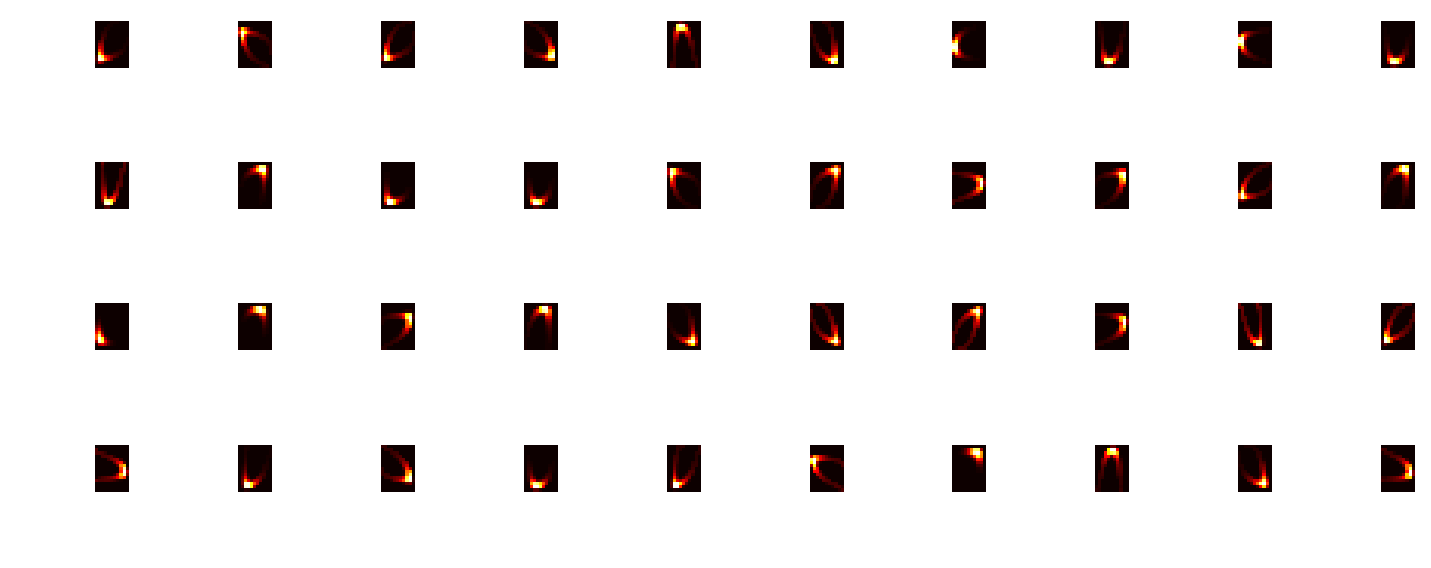

In [16]:
# Plotting a subset of iamges from the dataset.

plt.figure(figsize=(20, 8))
for i in range(40):
    plt.subplot(4, 10, i+1)
    idx = np.random.randint(0, N)
    plt.imshow(images[idx])
    plt.axis("off")
plt.tight_layout()
plt.show()

## 3. Make `tf.data.Dataset` objects
*  split your dataset to create `tf.data.Dataset` objects for training and validation data. 
* Using the `map` method, normalise the pixel values so that they lie between 0 and 1.
* These Datasets will be used to train a variational autoencoder (VAE). Use the `map` method to return a tuple of input and output Tensors where the image is duplicated as both input and output.
* Randomly shuffle the training Dataset.
* Batch both datasets with a batch size of 20, setting `drop_remainder=True`.
* Print the `element_spec` property for one of the Dataset objects.

In [17]:
def test_train_split(data, test_fraction):
    data = data.astype(dtype=np.float32)
    N = data.shape[0]
    test_idx = np.random.choice(np.arange(N), int(test_fraction*N), replace=False)
    train_idx = np.setdiff1d(np.arange(N), test_idx)

    return data[train_idx], data[test_idx]

In [18]:
def GetDataset(data, test_fraction, batch_size=20):
    train, test = test_train_split(data, test_fraction)

    train = tf.data.Dataset.from_tensor_slices(train)
    train = train.map(lambda x: x/255.0)
    train = train.map(lambda x: (x, x))
    train = train.batch(batch_size, drop_remainder=True)

    test = tf.data.Dataset.from_tensor_slices(test)
    test = test.map(lambda x: x/255.0)
    test = test.map(lambda x: (x, x))
    test = test.batch(batch_size, drop_remainder=True)

    return train, test

In [19]:
# Dataset Creation

batch_size = 20
train_data, test_data = GetDataset(images, 0.2)

print(train_data.element_spec)
print(test_data.element_spec)

(TensorSpec(shape=(20, 36, 36, 3), dtype=tf.float32, name=None), TensorSpec(shape=(20, 36, 36, 3), dtype=tf.float32, name=None))
(TensorSpec(shape=(20, 36, 36, 3), dtype=tf.float32, name=None), TensorSpec(shape=(20, 36, 36, 3), dtype=tf.float32, name=None))


## 4. Build the encoder and decoder networks
* now create the encoder and decoder for the variational autoencoder algorithm.


In [20]:
# Image Dimensions

image_dims = images.shape[1:]
image_dims

(36, 36, 3)

In [21]:
# Latent Space Dimension

latent_dim = 2

In [22]:
def get_prior(latent_dim):
    prior = tfd.MultivariateNormalDiag(loc = tf.Variable(tf.zeros(latent_dim), dtype=tf.float32),
                                       scale_diag = tfp.util.TransformedVariable(initial_value = tf.ones(latent_dim, dtype=tf.float32),
                                                                                 bijector = tfb.Softplus(),
                                                                                 dtype = tf.float32)
                                       )
    
    return prior

In [23]:
def get_encoder(latent_dim):
    prior = get_prior(latent_dim)

    model = models.Sequential([
                               layers.InputLayer(input_shape=image_dims),
                               
                               layers.Conv2D(filters=32, kernel_size=(3,3)),
                               layers.BatchNormalization(),
                               layers.LeakyReLU(0.2),

                               layers.Conv2D(filters=64, kernel_size=(3,3)),
                               layers.BatchNormalization(),
                               layers.LeakyReLU(0.2),

                               layers.Conv2D(filters=128, kernel_size=(3,3)),
                               layers.BatchNormalization(),
                               layers.LeakyReLU(0.2),

                               layers.Conv2D(filters=256, kernel_size=(3,3)),
                               layers.BatchNormalization(),
                               layers.LeakyReLU(0.2),

                               layers.Conv2D(filters=8, kernel_size=(1,1)),
                               layers.BatchNormalization(),

                               layers.Flatten(),

                               layers.Dense(100),
                               layers.BatchNormalization(),
                               layers.LeakyReLU(0.2),

                               layers.Dense(tfpl.MultivariateNormalTriL.params_size(latent_dim)),
                               tfpl.MultivariateNormalTriL(latent_dim),

                               tfpl.KLDivergenceAddLoss(prior, 
                                                        use_exact_kl = False,
                                                        test_points_fn = lambda q:q.sample(5),
                                                        test_points_reduce_axis=(0,1))
    ])

    return model

In [24]:
enc_model = get_encoder(latent_dim)

enc_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 34, 34, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 34, 34, 32)       128       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 34, 34, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 64)        0

In [25]:
def get_decoder(latent_dim, image_dim):
    model = models.Sequential([
                               layers.InputLayer(input_shape=(latent_dim,)),

                               layers.Dense(64),
                               layers.BatchNormalization(),
                               layers.LeakyReLU(0.2),

                               layers.Dense(128),
                               layers.BatchNormalization(),
                               layers.LeakyReLU(0.2),

                               layers.Dense(256),
                               layers.BatchNormalization(),
                               layers.LeakyReLU(0.2),

                               layers.Reshape(target_shape=(8, 8, 4)),

                               layers.UpSampling2D(size=(3,3)),
                               layers.Conv2D(filters=128, kernel_size=(3,3)),
                               layers.BatchNormalization(),
                               layers.LeakyReLU(0.2),

                               layers.UpSampling2D(size=(2, 2)),
                               layers.Conv2D(filters=64, kernel_size=(3,3)),
                               layers.BatchNormalization(),
                               layers.LeakyReLU(0.2),

                               layers.Conv2D(filters=32, kernel_size=(3,3)),
                               layers.BatchNormalization(),
                               layers.LeakyReLU(0.2),
        
                               layers.Conv2D(filters=16, kernel_size=(3,3)),
                               layers.BatchNormalization(),
                               layers.LeakyReLU(0.2),

                               layers.Conv2D(filters=1, kernel_size=(3, 3), strides=(2,2)),
                               layers.BatchNormalization(),
                               layers.LeakyReLU(0.2),

                               layers.Flatten(),

                               layers.Dense(tfpl.IndependentBernoulli.params_size(image_dim)),

                               tfpl.IndependentBernoulli(event_shape=image_dim)
    ])

    return model

dec_model = get_decoder(latent_dim, image_dims)
dec_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 64)                192       
                                                                 
 batch_normalization_6 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 128)               8320      
                                                                 
 batch_normalization_7 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 128)              

## 5. Train the variational autoencoder


In [26]:
# Reconstruction Loss

NLL = lambda real, estimated: -tf.reduce_mean(estimated.log_prob(real))

In [27]:
# Variational Autoencoder

def get_vae(encoder, decoder):
    vae = models.Model(inputs = encoder.inputs, 
                      outputs= decoder(encoder.outputs))

    vae.compile(optimizer="adam", loss=NLL)

    return vae

In [28]:
vae_model = get_vae(enc_model, dec_model)
vae_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 36, 36, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 34, 34, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 34, 34, 32)       128       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 34, 34, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                             

In [30]:
# Model Training

es_callback = callbacks.EarlyStopping(monitor="val_loss", 
                                      min_delta=0.1, 
                                      patience=8, 
                                      restore_best_weights=True)


history = vae_model.fit(train_data, 
                        validation_data=test_data,
                        epochs=500, 
                        callbacks=[es_callback])

Epoch 1/500
100/100 [==============================] - 583s 6s/step - loss: 69.2736 - val_loss: 68.6604
Epoch 2/500
100/100 [==============================] - 578s 6s/step - loss: 69.8480 - val_loss: 78.1538
Epoch 3/500
100/100 [==============================] - 568s 6s/step - loss: 68.7823 - val_loss: 78.8675
Epoch 4/500
100/100 [==============================] - 580s 6s/step - loss: 67.3828 - val_loss: 75.2706
Epoch 5/500
100/100 [==============================] - 574s 6s/step - loss: 67.1447 - val_loss: 74.1782
Epoch 6/500
100/100 [==============================] - 561s 6s/step - loss: 67.0392 - val_loss: 68.7398
Epoch 7/500
100/100 [==============================] - 576s 6s/step - loss: 65.8050 - val_loss: 70.4922
Epoch 8/500
100/100 [==============================] - 548s 5s/step - loss: 65.2105 - val_loss: 65.2229
Epoch 9/500
100/100 [==============================] - 554s 6s/step - loss: 65.2004 - val_loss: 65.8813
Epoch 10/500
100/100 [==============================] - 578s 6s/

In [31]:
# Save Mode Weights

vae_model.save_weights('/content/my_checkpoint')

PermissionDeniedError: /content; Permission denied

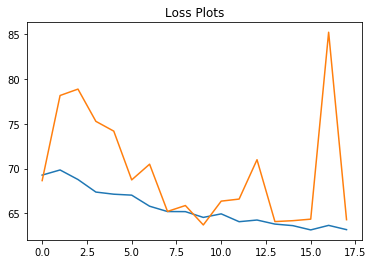

In [32]:
# Training Visualization

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Loss Plots")

plt.show()

## 6. Use the encoder and decoder networks


In [33]:
# Sampling the Images fom Dataset

N = 1000
idx = np.random.choice(np.arange(images.shape[0]), N)

embeddings = enc_model(images[idx]/255.0).mean()

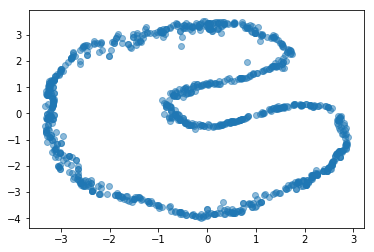

In [34]:
# Embedding Visualization

plt.scatter(embeddings[:,0], embeddings[:,1], alpha=0.5)
plt.show()

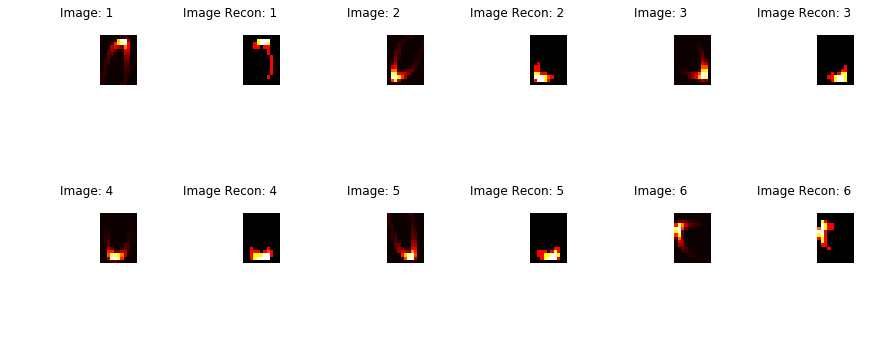

In [35]:
# Images an Reocnstructed Image Pairs

N = 6
idx = np.random.choice(np.arange(images.shape[0]), N) 
rec_images = vae_model(images[idx]).mean().numpy()

plt.figure(figsize=(15, 6))
for i in range(N):
    plt.subplot(2, 6, 2*i+1)
    plt.imshow(images[idx[i]])
    plt.title("Image: {}".format(i+1))
    plt.axis("off")

    plt.subplot(2, 6, 2*i+2)
    plt.imshow(rec_images[i])
    plt.title("Image Recon: {}".format(i+1))
    plt.axis("off")
plt.show()

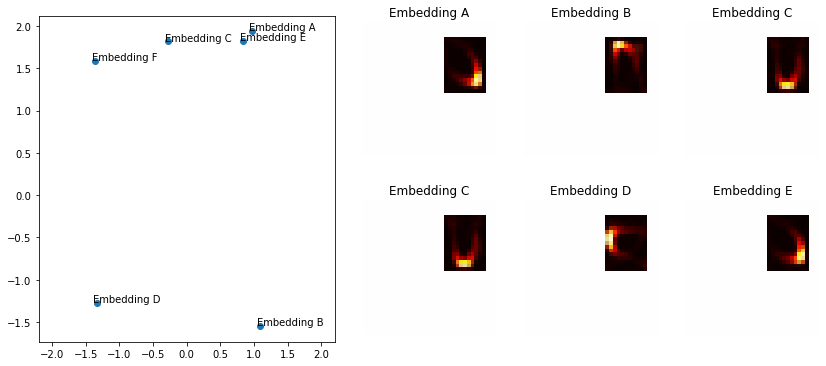

In [36]:
# Random Latent Space Embedding Visualization

N = 6
embeddings = np.random.uniform(-2, 2, (N, latent_dim))
rec_images = dec_model(embeddings).mean()


fig = plt.figure(figsize=(14, 6)) 
gs = gridspec.GridSpec(2, 5) 

ax0 = plt.subplot(gs[:, 0:2])
ax0.scatter(embeddings[:, 0], embeddings[:, 1])
for i in range(N):
    ax0.annotate("Embedding "+chr(ord("A")+i), (embeddings[i, 0]-0.05, embeddings[i, 1]+7e-3))
ax0.set_xlim(-2.2, 2.2)

for i in range(2):
    for j in range(3):
        ax1 = plt.subplot(gs[i, 2+j])
        ax1.imshow(rec_images[2*i + j])
        ax1.set_axis_off()
        ax1.set_title("Embedding "+chr(ord("A")+(2*i + j)))

plt.show()

## Make a video of latent space interpolation 

In [37]:
# Function to create animation

import matplotlib.animation as anim
from IPython.display import HTML


def get_animation(latent_size, decoder, interpolation_length=500):
    assert latent_size >= 2, "Latent space must be at least 2-dimensional for plotting"
    fig = plt.figure(figsize=(9, 4))  
    ax1 = fig.add_subplot(1,2,1)
    ax1.set_xlim([-3, 3])
    ax1.set_ylim([-3, 3])
    ax1.set_title("Latent space")
    ax1.axes.get_xaxis().set_visible(False)
    ax1.axes.get_yaxis().set_visible(False)
    ax2 = fig.add_subplot(1,2,2)
    ax2.set_title("Data space")
    ax2.axes.get_xaxis().set_visible(False)
    ax2.axes.get_yaxis().set_visible(False)

    # initializing a line variable 
    line, = ax1.plot([], [], marker='o')
    img2 = ax2.imshow(np.zeros((36, 36, 3)))

    freqs = np.random.uniform(low=0.1, high=0.2, size=(latent_size,))
    phases = np.random.randn(latent_size)
    input_points = np.arange(interpolation_length)
    latent_coords = []
    for i in range(latent_size):
        latent_coords.append(2 * np.sin((freqs[i]*input_points + phases[i])).astype(np.float32))

    def animate(i): 
        z = tf.constant([coord[i] for coord in latent_coords])
        img_out = np.squeeze(decoder(z[np.newaxis, ...]).mean().numpy())
        line.set_data(z.numpy()[0], z.numpy()[1])
        img2.set_data(np.clip(img_out, 0, 1))
        return (line, img2)

    return anim.FuncAnimation(fig, animate, frames=interpolation_length, 
                              repeat=False, blit=True, interval=150)

In [42]:
# Create the animation
a = get_animation(latent_size, decoder, interpolation_length=200)
HTML(a.to_html5_video())
